# Connectivity Restrictions on the Three Qubit Code

If there is a file import error make sure you are in the correct path

In [ ]:
import sys
sys.path.append('..')   # the `general_qec` package sits above us

In [ ]:
import numpy as np
import random
from general_qec.qec_helpers import *
from general_qec.gates import *
from circuit_specific.three_qubit_helpers import *
from circuit_specific.drawing_helpers import *

# Importing required libraries for qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace
from qiskit.extensions import UnitaryGate

# Initialize backends simulators to visualize circuits
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}   # -> don't think we need this, just creates an empty "{}" file...
user_config.set_config('circuit_drawer', 'mpl')

## Contents
1. [Introduction](#introduction)
2. [Line Connectivity](#lineconnectivity)
3. [Grid Connectivity](#gridconnectivity)
    1. [The error correction process](#process)
    2. [Circuit Drawing](#griddrawing)
    3. [Implementing grid connectivity](#impementation)

## 1. Introduction <a id='introduction'></a>

During our previous implementation of the three qubit code we used all-to-all connectivity, which means that all qubits are coupled to each other. This allows us to implement any two qubit gate from any one qubit to another using only one single gate. However, this is not the case in physical systems. In reality physical systems will be able to couple only a few qubits to each other. This will impact the probability of error due to the fact that we will now need to implement a much larger number of gates that before, and these gates always have some sort of probability for error.

## 2. Line Connectivity <a id='lineconnectivity'></a>

Line connectivity is when we only allow adjacent qubits to interact when qubits are organized on a line, like so:

```
... ---Qubit---Qubit---Qubit--- ...
```

Thus, our gates that cause non-adjacent qubits to interact will need to be broken up into gates between adjacent qubits by using `SWAP` gates to flip qubits until they are adjacent (and then back).

Thus if we look at our current three qubit code, we can see that we will need to change the CNOT gates that couple the data qubits to the syndrome ancilla qubits.

In [ ]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
syndrome_ancilla = QuantumRegister(2, 'syndrome |0⟩')
classical_bits = ClassicalRegister(2, 'classical_measurement')
qc = QuantumCircuit(psi, ancilla, syndrome_ancilla, classical_bits)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.barrier(0,1,2) # A bit flip error occurs here
qc.cnot(0, 3)
qc.cnot(1, 3)
qc.cnot(0, 4)
qc.cnot(2, 4)
qc.measure(syndrome_ancilla, classical_bits)
qc.barrier()
qc.draw()

To change the circuit above we can actually implement our method for deriving the non-adjacent CNOT gates.

We use results from the 3-qubit code tutorial, and Proposition 8 of this [document](https://hal-normandie-univ.archives-ouvertes.fr/hal-02948598/document). We let $ i_1, i_2, ..., i_p \space (p - 1 \ge 2) $ be distinct integers such that

$$
CNOT_{i_1, i_p} = \biggl(CNOT_{i_1, i_2}CNOT_{i_2, i_3} . . . CNOT_{i_{p-2}, i_{p-1}}CNOT_{i_{p-1}, i_p}CNOT_{i_{p-2}, i_{p-1}} . . . CNOT_{i_2, i_3}\biggr)^2
$$

We can see the circuit for this below, where the barriers in between gates are used to separate the different CNOT gates for visual aid. The first barrier is still a bit flip error, and the last barrier is a correction, like before. Obviously this circuit has many more gates that we need to apply, however it still serves the same purpose. We could also rearrange the qubit positions in the line to optimize the number of gates that we use and reduce them, but that is not done here.

In [ ]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
syndrome_ancilla = QuantumRegister(2, 'syndrome |0⟩')
classical_bits = ClassicalRegister(2, 'classical_measurement')
qc = QuantumCircuit(psi, ancilla, syndrome_ancilla, classical_bits)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.barrier(0,1,2) # A bit flip error occurs here

# First non-adj CNOT
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.cnot(2, 3)
qc.cnot(1, 2)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.cnot(2, 3)
qc.cnot(1, 2)
qc.barrier()

# Second non_adj CNOT
qc.cnot(1, 2)
qc.cnot(2, 3)
qc.cnot(1, 2)
qc.cnot(2, 3)
qc.barrier()

# Third non_adj CNOT
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.cnot(2, 3)
qc.cnot(3, 4)
qc.cnot(2, 3)
qc.cnot(1, 2)
qc.cnot(0, 1)
qc.cnot(1, 2)
qc.cnot(2, 3)
qc.cnot(3, 4)
qc.cnot(2, 3)
qc.cnot(1, 2)
qc.barrier()

# Fourth non_adj CNOT
qc.cnot(2, 3)
qc.cnot(3, 4)
qc.cnot(2, 3)
qc.cnot(3, 4)
qc.barrier()


qc.measure(syndrome_ancilla, classical_bits)
qc.barrier()
qc.draw()

In our `non_adj_CNOT` funciton we create a CNOT matrix representation for any CNOT gate that does not occur between adjacent qubits. In reality when we do this derivation, we use the properties of line-to-line connectivity to create the matrix. This process is shown below, and it uses the formula from above. Therefore, the implementation for line connectivity would be the same in terms of the CNOT gate operations we make to create this final matrix.

Thus if we wanted to add in some error cost for each individual gate being applied we could easily do that by applying the two qubit gate error at the creation of each gate.

I point out the part that actually uses the line connectivity and multiplies all of the adjacent qubit CNOT gates together.

In [ ]:
### Implement a non-adjacent CNOT gate between 2 qubits in a system ###
def non_adj_CNOT(control, target, tot_qubits):
# control: control qubit index (starting from 0)
# target: target qubit index (starting from 0) (must be a larger index than control)
# tot_qubits: total number of qubits in the system (if there are 5 qubits then put 5 ...)

    p = target - control # used to index over all gates neeeded to compose final gate
    all_dots = np.array([[]]) # array used to keep track of the components we will combine at the end


# - - - - - - - - - - - - - -  Line Connectivity Formula - - - - - - - - - - - - - - #

    # Indexing over the values of p to get the first half of the formula
    for j in range(p):
        # Sets the next component of the matrix multiplication up (an individual CNOT gate)
        next_dot = np.kron(np.identity(2**(j)), np.kron(cnot, np.identity(2**(p-j-1))))

        # Adds the components to the array and multiplies them together (each indifidual CNOT gate multiplied)
        if j == 0:
            all_dots = np.array([next_dot])
            gate = all_dots[j]
        else:
            all_dots = np.append(all_dots, [next_dot], axis = 0)
            gate = np.dot(gate, all_dots[j])

    # Indexing over values of p such that we get the 2nd half of the equation together (each indifidual CNOT gate multiplied)
    for j in range(p - 2):
        gate = np.dot(gate, all_dots[p-j-2])

    # Squares the final matrix
    final_gate = np.dot(gate, gate)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # Adds the dimensions needed depending on the tot_qubits
    n1 = control # exponent used to tensor the left side identity matrix for our full system
    n2 = tot_qubits - target - 1 # exponent used to tensor the right side identity matrix for our full system
    final_total_gate = np.kron(np.identity(2**(n1)), np.kron(final_gate, np.identity(2**(n2))))

    return final_total_gate

## 3. Grid Connectivity <a id='gridconnectivity'></a>

Another type of connectivity is grid connectivity, which occures when we have our qubits in a latice like structure. In this case we have more flexibility than line connectivity since some qubits will be able to couple to more than just a maximum of two qubits. There are multiple possible lattice configurations, but we restrict our attention to the (maximally dense) square lattice.

In the case of the 3 qubit code, we use 5 qubits total (3 data, 2 ancilla). So we can use a 2 x 3 grid of qubits, and only program 5 of them, with one additional qubit that is not in our system. Thus here we have an example for the grid connectivity of our system with 6 qubits. Again, we did not optimize the layout to reduce the number of gates needed to perform quantum error correction on this system. 

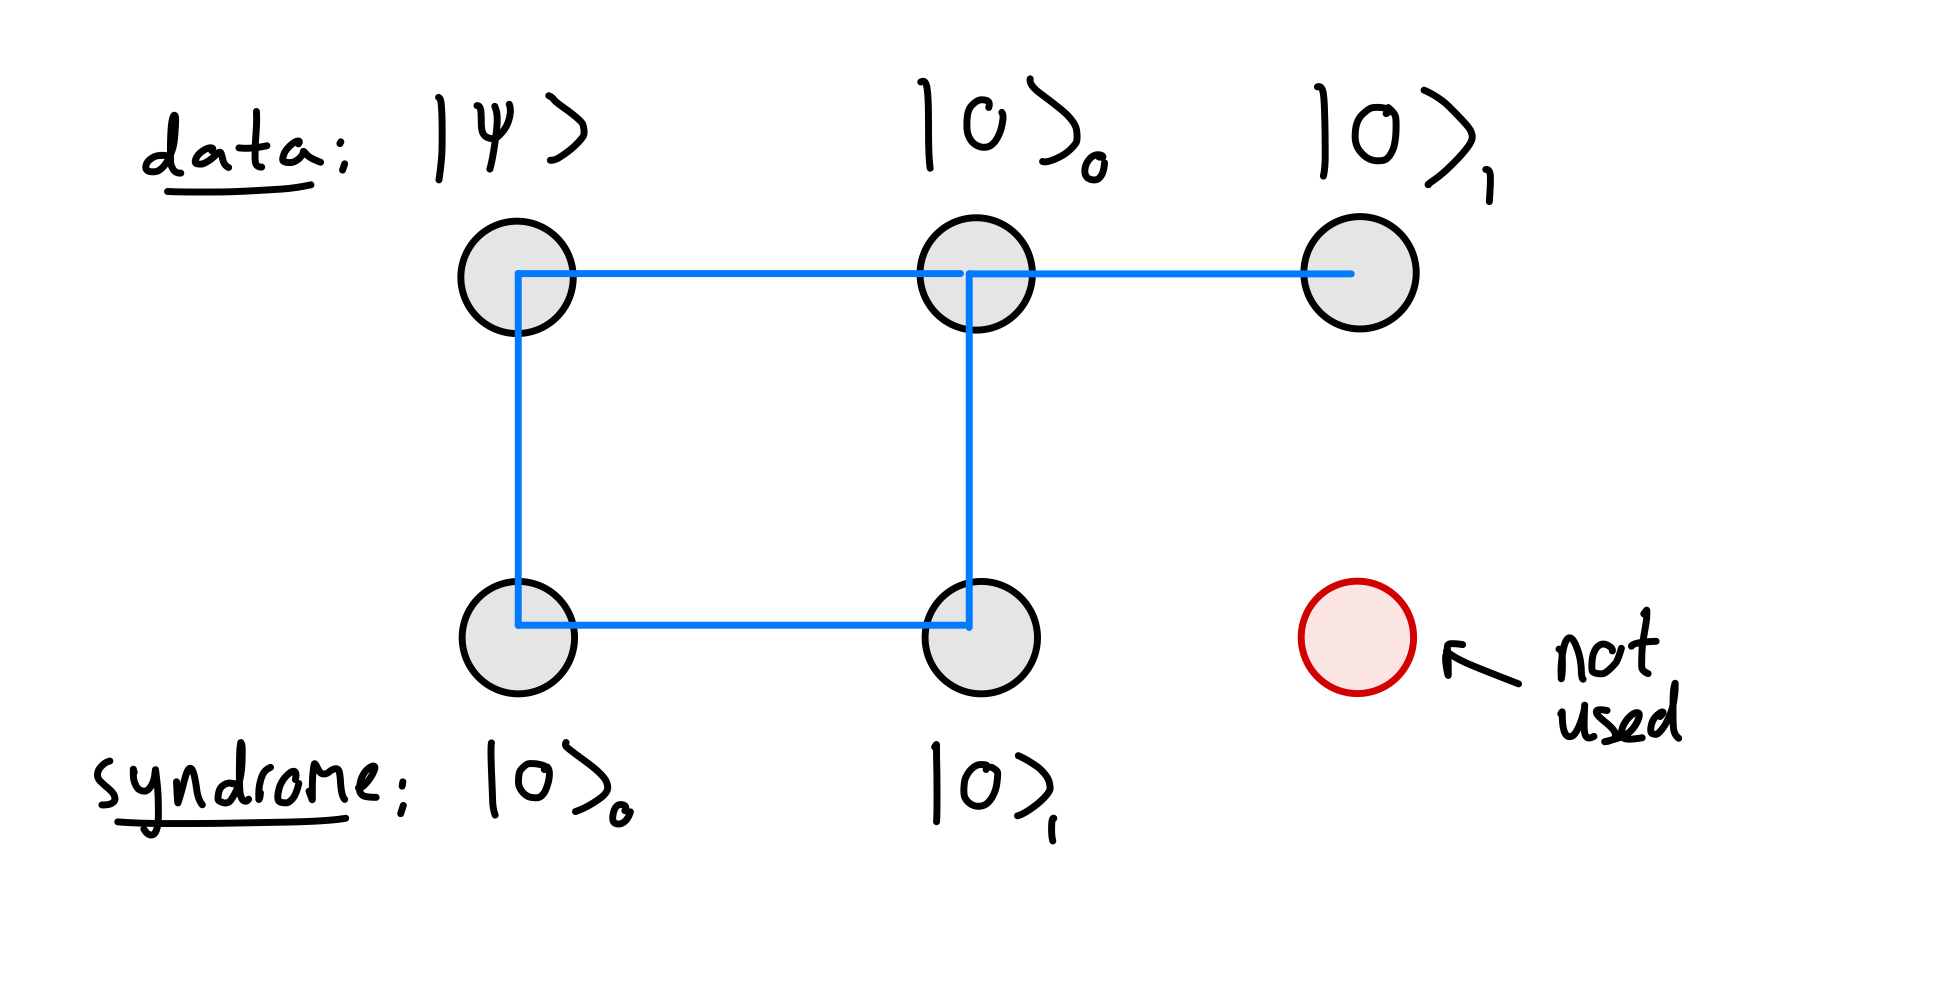

### A. The error correction process <a id='process'></a>

We will now go over the step-by-step process of gates when this 3 qubit code using grid connectivity.

1. State Initialization

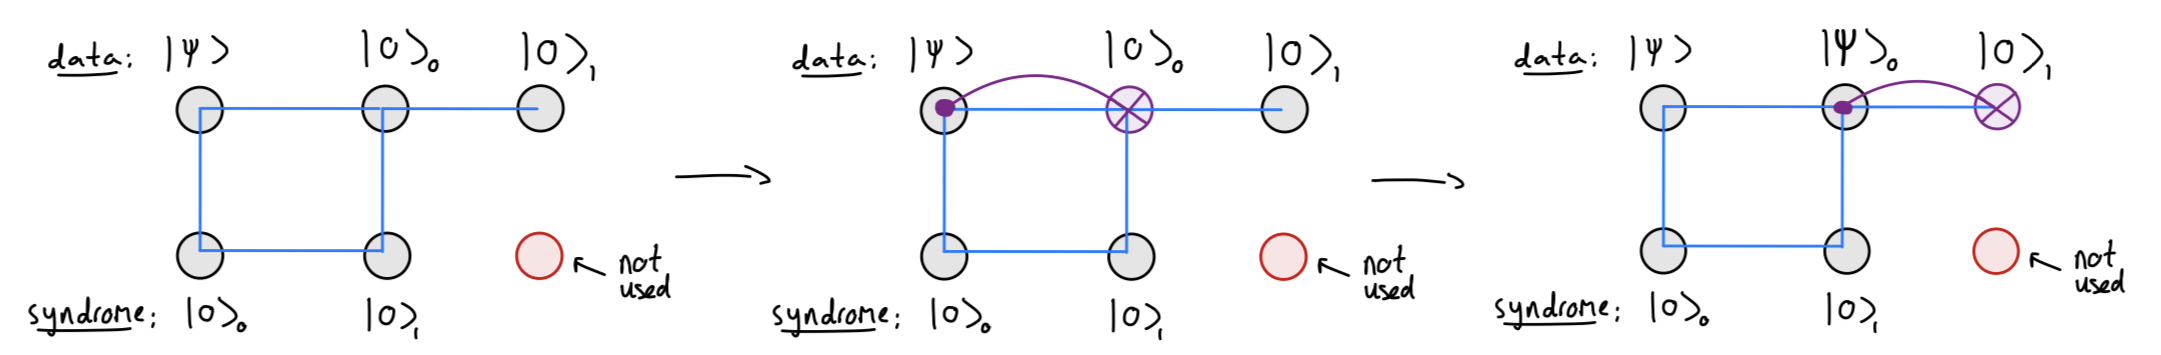

2. Error Occurs on Logical State $\vert\psi\rangle_L$ and we start applying ancilla gates

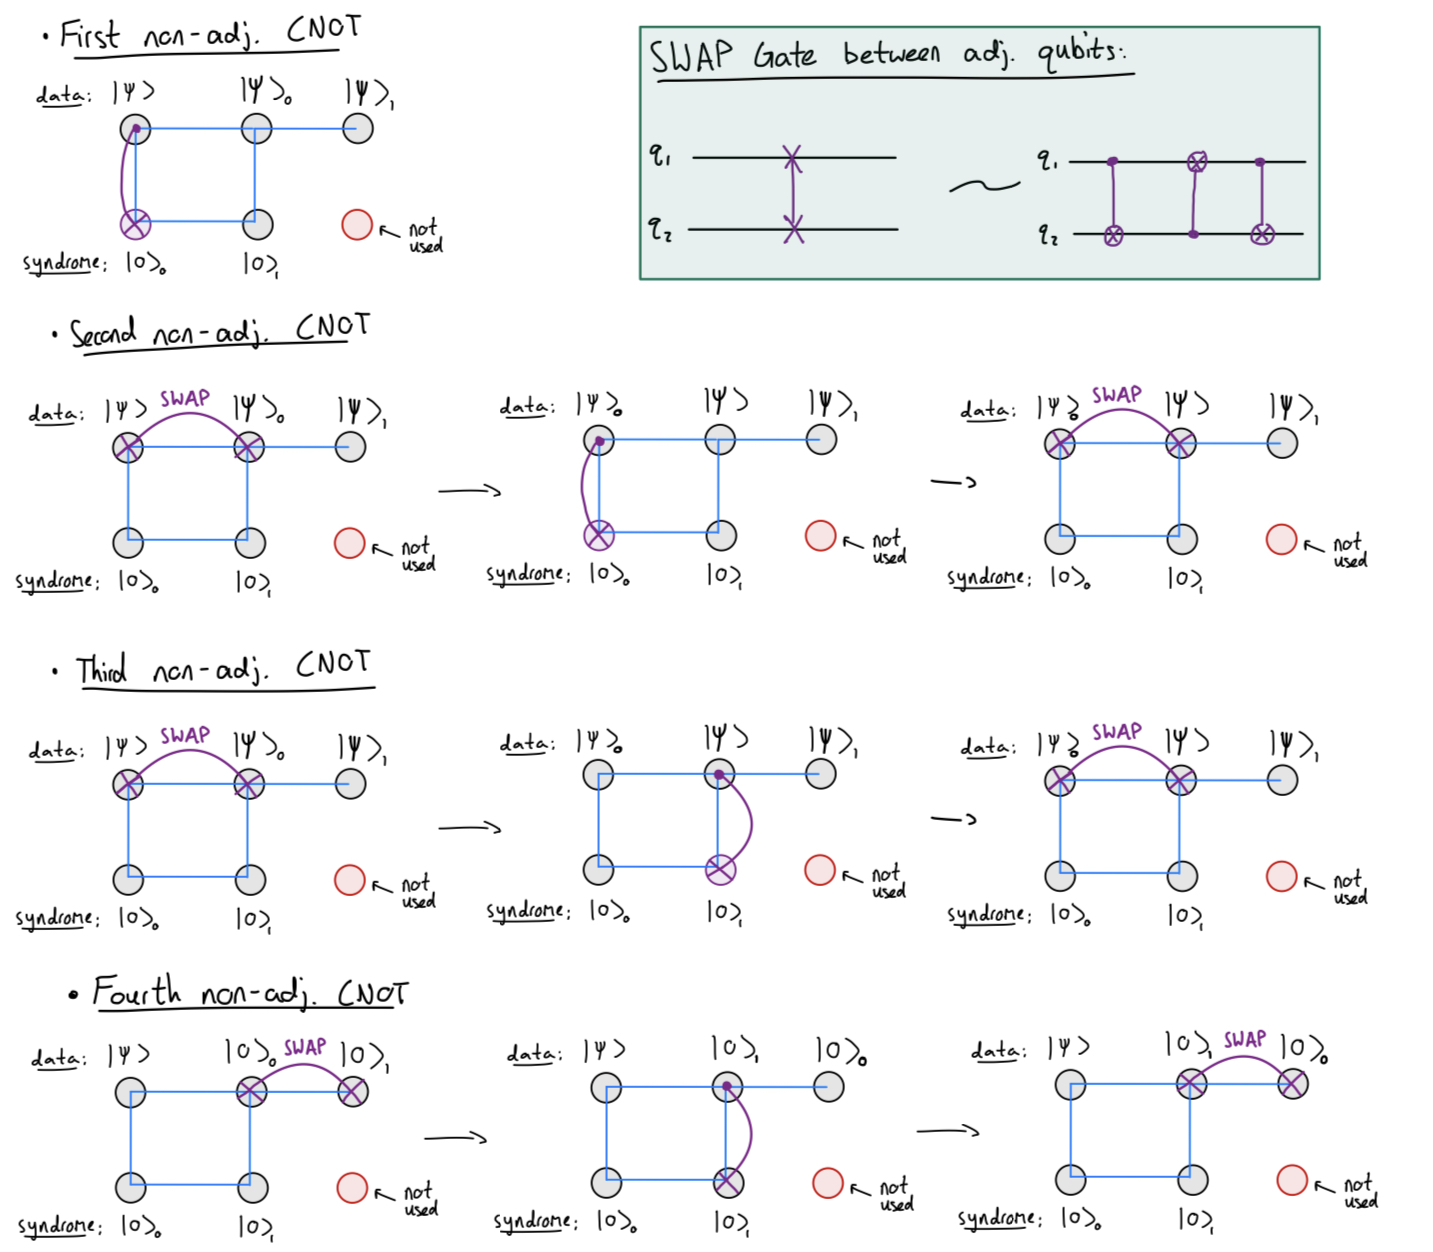

3. Apply our error correction based on syndrome measuremnts

### B. Circuit Drawing <a id='griddrawing'></a>

Remember that even though some of the gates are not adjacent in the circuit, they act on qubits that are coupled in our grid connectivity.

In [ ]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(2, '|0⟩')
syndrome_ancilla = QuantumRegister(2, 'syndrome |0⟩')
classical_bits = ClassicalRegister(2, 'classical_measurement')
qc = QuantumCircuit(psi, ancilla, syndrome_ancilla, classical_bits)
qc.cnot(0, 1)
qc.cnot(1, 2)

qc.barrier(0,1,2) # A bit flip error occurs here

# First non-adj CNOT
qc.cnot(0, 3)
qc.barrier()

# Second non_adj CNOT
# SWAP
qc.cnot(0, 1)
qc.cnot(1, 0)
qc.cnot(0, 1)
# CNOT
qc.cnot(0, 3)
# SWAP
qc.cnot(0, 1)
qc.cnot(1, 0)
qc.cnot(0, 1)
qc.barrier()

# Third non_adj CNOT
# SWAP
qc.cnot(0, 1)
qc.cnot(1, 0)
qc.cnot(0, 1)
# CNOT
qc.cnot(1, 4)
# SWAP
qc.cnot(0, 1)
qc.cnot(1, 0)
qc.cnot(0, 1)
qc.barrier()

# Fourth non_adj CNOT
# SWAP
qc.cnot(1, 2)
qc.cnot(2, 1)
qc.cnot(1, 2)
# CNOT
qc.cnot(1, 4)
# SWAP
qc.cnot(1, 2)
qc.cnot(2, 1)
qc.cnot(1, 2)
qc.barrier()


qc.measure(syndrome_ancilla, classical_bits)
qc.barrier()
qc.draw()

### C. Implementing grid connectivity <a id='impementation'></a>

Here we will show the implementation of grid connectivity when using the 3 qubit code.

In [ ]:
# We can initialize our logical state as usual because the connectivity we chose does not effect this step
# initial_psi = np.array([0, 1])

initial_psi = 1/np.sqrt(2) * np.array([1, 1])

initial_state = three_qubit_initialize_logical_state(initial_psi)

print('Initialized logical state: (by amplitude) ')
print_state_info(initial_state, 3)

In [ ]:
# Here we apply the bit flip error like usual becuse it acts on a random single qubit
error_state, index = three_qubit_random_qubit_x_error(initial_state)

# Apply the ancilla qubits as |0> states
full_error_state = np.kron(error_state, np.kron(zero, zero))

print('Errored logical state: ')
print_state_info(full_error_state, 5)

In [ ]:
# Now we apply all of the CNOT gates in the circuit above
# (note that cnot01 means a cnot gate with 0 as the contrl and 1 as the target qubits)

# First non-adj CNOT
cnot03 = CNOT(0, 3, 5)

# Second non-adj CNOT
cnot01 = CNOT(0, 1, 5)
cnot10 = CNOT(1, 0, 5)
cnot13 = np.dot(cnot01, np.dot(cnot10, np.dot(cnot01, np.dot(cnot03, np.dot(cnot01, np.dot(cnot10, cnot01))))))

# Third non-adj CNOT
cnot14 = CNOT(1, 4, 5)
cnot04 = np.dot(cnot01, np.dot(cnot10, np.dot(cnot01, np.dot(cnot14, np.dot(cnot01, np.dot(cnot10, cnot01))))))

# Fourth non-adj CNOT
cnot12 = CNOT(1, 2, 5)
cnot21 = CNOT(2, 1, 5)
cnot24 = np.dot(cnot12, np.dot(cnot21, np.dot(cnot12, np.dot(cnot14, np.dot(cnot12, np.dot(cnot21, cnot12))))))


total_gate = np.dot(cnot03, np.dot(cnot13, np.dot(cnot04, cnot24)))

final_state = np.dot(total_gate, full_error_state)

print('Ancillas applied logical state: ')
print_state_info(final_state, 5)

In [ ]:
# We can now correct for the error using the ancilla measurements
corrected_state = three_qubit_correct_x_error(final_state)

print('Corrected logical state: ')
print_state_info(corrected_state, 5)

As you can see our result will be the corrected state with the syndrome ancilla detecting where this error occured in the same way we have done before.